In [5]:
import numpy as np
import numpy.random as R
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, Dropout, MaxPooling2D, Embedding, Concatenate
import matplotlib.pyplot as plt
from tqdm import tqdm

# limit threads for learning environment
import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(4)
tf.config.threading.set_inter_op_parallelism_threads(4)

In [3]:
def load_real_samples():
    (x_train, y_train), (_, _) = load_data()
    # limit dataset size to speed example
    limit=12800
    x_train = x_train[:limit]
    y_train = y_train[:limit]
    X = np.expand_dims(x_train, axis=-1)
    X = X.astype('float32')
    X = (X - 127.5) / 127.5
    return [X, y_train]

In [6]:
dataset = load_real_samples()
print(dataset[0].shape)

(12800, 28, 28, 1)


In [9]:
def save_plot(examples, n=10):
    plt.figure(figsize=(10,10))
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i].reshape(28,28), cmap='gray_r')
#     filename = 'contents/generated_plot.png'
    plt.show()
    plt.savefig(filename)
    plt.close()

dataset = load_real_samples()
print(dataset[0].shape)

(12800, 28, 28, 1)


(100, 28, 28, 1)


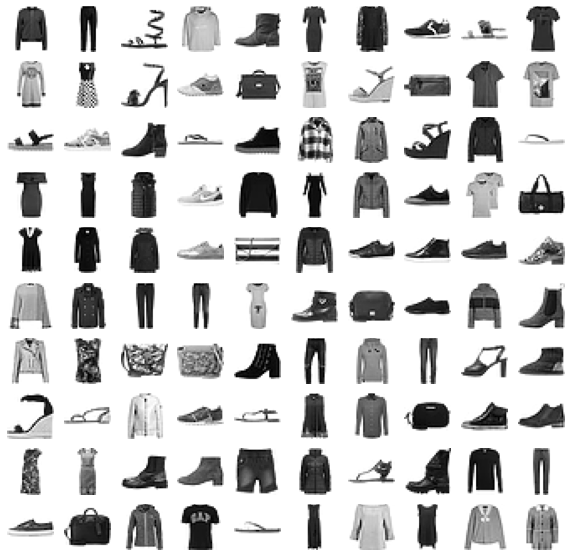

NameError: name 'filename' is not defined

In [10]:
def generate_real_samples(dataset, n_samples):
    images, labels = dataset
    ix = R.randint(0, images.shape[0], n_samples)
    X, labels = images[ix], labels[ix]
    y = np.ones((n_samples, 1))
    return [X, labels], y

real,_ = generate_real_samples(dataset, 100)
print(real[0].shape)
save_plot(real[0])

In [11]:
latent_dim = 100

def build_generator(latent_dim, n_classes=10):
    in_label = Input(shape=(1,))
    label = Embedding(n_classes, 50)(in_label)
    n_nodes = 7 * 7
    label = Dense(n_nodes)(label)
    label = Reshape((7, 7, 1))(label)
    in_latent = Input(shape=(latent_dim,))
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_latent)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    merge = Concatenate()([gen, label])
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    model = Model([in_latent, in_label], out_layer)
    return model

generator = build_generator(latent_dim)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 6272)         633472      ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                              

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(100, 28, 28, 1)


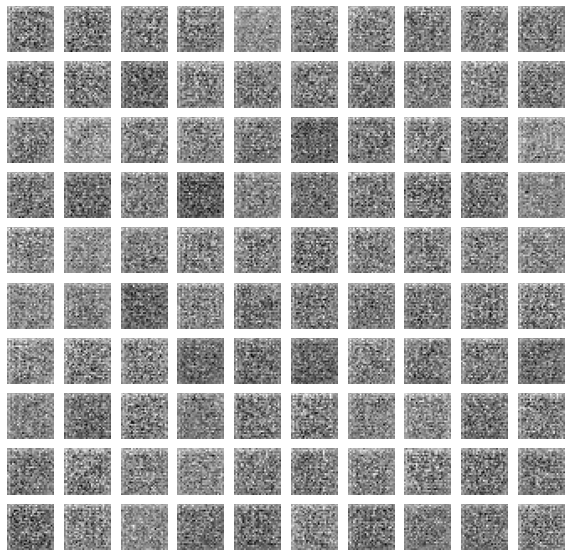

NameError: name 'filename' is not defined

In [12]:
def generate_latent_vector(latent_dim, n_samples, n_classes=10):
    x_input = R.randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    labels = R.randint(0, n_classes, n_samples)
    return [z_input, labels]

def generate_fake_samples(generator, latent_dim, n_samples):
    z_input, labels_input = generate_latent_vector(latent_dim, n_samples)
    images = generator.predict([z_input, labels_input])
    y = np.zeros((n_samples, 1))
    return [images, labels_input], y

fake,_ = generate_fake_samples(generator, latent_dim, 100)
print(fake[0].shape)
save_plot(fake[0])

In [13]:
def build_discriminator(in_shape=(28,28,1), n_classes=10):
    in_label = Input(shape=(1,))
    label = Embedding(n_classes, 50)(in_label)
    n_nodes = in_shape[0] * in_shape[1]
    label = Dense(n_nodes)(label)
    label = Reshape((in_shape[0], in_shape[1], 1))(label)
    in_image = Input(shape=in_shape)
    merge = Concatenate()([in_image, label])
    disc = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    disc = LeakyReLU(alpha=0.2)(disc)
    disc = Conv2D(128, (3,3), strides=(2,2), padding='same')(disc)
    disc = LeakyReLU(alpha=0.2)(disc)
    disc = Flatten()(disc)
    disc = Dropout(0.4)(disc)
    out_layer = Dense(1, activation='sigmoid')(disc)
    model = Model([in_image, in_label], out_layer)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_3[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 1, 784)       39984       ['embedding_1[0][0]']            
                                                                                                  
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                            

/Users/parzival2108/opt/anaconda3/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
def build_cgan(g_model, d_model):
    d_model.trainable = False
    gen_noise, gen_label = g_model.input
    gen_output = g_model.output
    gan_output = d_model([gen_output, gen_label])
    model = Model([gen_noise, gen_label], gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

cgan = build_cgan(generator, discriminator)
cgan.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 6272)         633472      ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                            

In [15]:
batch_size = 128
epochs = 1
bat_per_epo = int(dataset[0].shape[0] / batch_size)
half_batch = int(batch_size / 2)
for i in range(epochs):
    for j in tqdm(range(bat_per_epo)):
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        d_loss1, _ = discriminator.train_on_batch([X_real, labels_real], y_real)
        [X_fake, labels], y_fake = generate_fake_samples(generator, latent_dim, half_batch)
        d_loss2, _ = discriminator.train_on_batch([X_fake, labels], y_fake)
        [z_input, labels_input] = generate_latent_vector(latent_dim, batch_size)
        y_gan = np.ones((batch_size, 1))
        g_loss = cgan.train_on_batch([z_input, labels_input], y_gan)
    print('>Loss Discriminator: %.0f%%, %.0f%% , Generator: %.0f%%' % (d_loss1,d_loss2,g_loss))

  0%|          | 0/100 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

100%|██████████| 100/100 [02:20<00:00,  1.40s/it]

>Loss Discriminator: 1%, 0% , Generator: 1%


In [ ]:
def generated_plot(examples, n):
    plt.figure(figsize=(10,10))
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    filename = 'contents/generated_plot.png'
    plt.show()
    plt.savefig(filename)
    plt.close()

latent_vectors, labels = generate_latent_vector(100, 100)
labels = np.asarray([x for _ in range(10) for x in range(10)])
generated  = generator.predict([latent_vectors, labels])
generated = (generated + 1) / 2.0
generated_plot(generated, 10)